# Analysis of Phytoplankton data from FlowCam
The Flowcam is an automated system for image analysis. In the LifeWatch framework, the Flowcam is used to measure the biomass of phytoplankton in the water column. At a sampling station, 50L of sea surface water was collected using a stainless-steel bucket and filtered through a 55µm mesh size Apstein net (1.2 m long, 0.5 m diameter). The filtered sample is transferred to a plastic falcon and fixed with acid Lugol’s iodine solution (1-5%). Samples are stored in the dark at 4°C until laboratory processing. In the lab, samples are processed using the FlowCAM VS-4 bench model (Fluid Imaging Technologies, Yarmouth, Maine, U.S.A.) equipped with a Sony XCD SC90 digital grey-scale camera and VisualSpreadsheet® software (version 4.2.52). For more details on Flowcam methodology, see paper. The FlowCAM output consists of cropped image collages, image parameters, and processing metadata. This output is then linked to sampling metadata from the ships information system (MIDAS) and is uploaded to a central database. Convolutional neural networks (CNN) are trained on human validated images. The current model version can recognize over 90 FlowCAM image classes with an accuracy of around 87%. Cell densities are calculated using the filtered volume of sea surface water, the volume of the sample measured in the lab, the fluid volume imaged, the particle count measured by the FlowCAM device, and a dilution factor calculated from the dilution of samples based on the PPUI accounted for during the sample run:

$$density\:\frac{cells}{L} = \frac{particle\:count * sample\:volume\:(mL)}{fluid\:volume\:imaged\:(mL) * dilution\:factor * volume\:filtered\:(L)}$$

Once predictions have been manually verified, the resulting cell densities are aggregated per predicted taxonomic level and made available through the Belgian LifeWatch RShiny application available at https://rshiny.lifewatch.be/flowcam-data/. Since the upload did not happen yet, the recent data is downloaded directly from MongoDB using the [export R script](FlowCam_export.R). Let's first load and check this data.

In [111]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [112]:
# load data
flowcam = pd.read_csv('../data/raw/flowcam_export.csv')

# Removed JN identifiers from comments

In [113]:
flowcam = flowcam[['Taxon', 'Comments', 'density_cell_L']]

# Split comments into station and station suffix
flowcam['Station'] = flowcam.Comments.str.split('_').str[0]
flowcam['Station_suffix'] = flowcam.Comments.str.split('_').str[1]

In [114]:
# Remove uninteresting stuff
taxa_to_delete = ['Artefact',
                  'Bubbles',
                  #'Detritus', 
                  'Fibers',
                  'Pollen',
                  'Remnant',
                  'Replicate',
                  'Unknown',
                  'Zooplankton',
                  'Aggregate',
                  'Unknown_5',
                  'Unknown_3',
                  'Holothuroidea ossicles',
                  'Ditylum brightwellii:process',
                  'Biddulphianae:process',
                  'Rhizosolenia:process',
                  'Faecal pellet',
                  'Egg/Cyst',
                  'Crustaceae:part']

flowcam = flowcam.query('Taxon not in @taxa_to_delete')

In [115]:
# Group taxon levels into new identifiers
flowcam['Taxon']

diatoms = ['Actinoptychus','Actinoptychus senarius','Actinoptychus splendens','Bacillaria paxillifer','Bacillariophyceae','Bacteriastrum',
           'Bellerochea horologicalis','Biddulphianae', 'Brockmanniella brockmannii', 'Centric Diatom','Ceratium horridum/C. longipes','Chaetoceros','Chaetoceros danicus',
           'Dactyliosolen/Cerataulina/Guinardia','Diploneis','Ditylum brightwellii','Eucampia','Guinardia delicatula','Guinardia flaccida',
           'Guinardia striata/Dactyliosolen phuketensis','Helicotheca tamesis','Hobaniella longicruris','Lauderia/Melosira/Detonula', 'Thalassiosira/Porosira',
           'Lithodesmium undulatum','Long (chained) diatom','Melosira','Neocalyptrella robusta','Odontella rhombus f. trigona','Paralia', 'Asterionella',
           'Pennate Diatom','Proboscia indica','Protoperidinium','Pseudo-nitzschia','Rhizosolenia','Rhizosolenia setigera (f. pungens)/R. hebetata f. semispina',
           'Skeletonema','Stellarima stellaris/Podosira/Hyalodiscus','Synedra/Thalassionema','Triceratium favus','Trieres mobiliensis/T. regia','Trieres sinensis',
           'Zygoceros','Aulacodiscus argus','Biddulphia alternans','Chaetoceros socialis','Coscinodiscus concinnus','Coscinodiscus granii','Coscinodiscus wailesii',
           'Foraminifera','Leptocylindraceae','Plagiogrammopsis/Bellerochea malleus','Stephanopyxis','Thalassiosira/Porosira''Asterionella', 'Auliscus', 'Chaetoceros curvisetus/C. pseudocurvisetus',
           'Meuniera membranacea', 'Odontella type 1', 'Proboscia', 'Proboscia alata', 'Ralfsiella smithii', 'Thalassiosira punctigera', 'Plagiogrammopsis vanheurckii', '(Pseudo-)pediastrum', 
       'Odontella aurita/Ralfsiella minima', 'Odontella rhombus var. trigona', 'Epiphytic diatom', 'Pennate diatom colony']

dinoflagellates = ['Ceratium horridum/C. longipes', 'Dinoflagellata', 'Dinoflagellate cyst', 'Noctiluca scintillans', 'Noctilucales', 'Protoperidinium', 'Protoperidinium pentagonum',
                   'Pseudo-nitzschia', 'Tripos', 'Tripos fusus', 'Tripos:part', 'Protoperidinium depressum', 'Dinophysis', 'Gymnodiniales', 'Tripos lineatus', 'Dissodinium pseudolunula']

prymnesiophyceae = ['Phytoplankton Colony'] # Phytoplankton colonies are phaeocystis parts

ciliates = ['Favella', 'Tintinnid cyst', 'Tintinnina', 'Tintinnopsis', 'Xystonella', 'Amphorellopsis','Ciliophora','Euntintinnus', 
            'Peritrichia', 'Strombidium', 'Ciliophora:part', 'Suctoria']

mollusca = ['Mollusca', 'Mollusca incertae', 'Veliger larvae D-shaped']

crustaceae = ['Nauplii', 'Decapoda', 'Copepoda adult', 'Crustacea']

annelida = ['Polychaeta']

echinodermata = ['Ophiuroidea/Echinoidea larvae']

# Swap the taxon names for the new identifiers
flowcam['Taxon_grouped'] = flowcam['Taxon'].replace(diatoms, 'Bacillariophyta')
flowcam['Taxon_grouped'] = flowcam['Taxon_grouped'].replace(dinoflagellates, 'Dinophyceae')
flowcam['Taxon_grouped'] = flowcam['Taxon_grouped'].replace(prymnesiophyceae, 'Prymnesiophyceae')
flowcam['Taxon_grouped'] = flowcam['Taxon_grouped'].replace(ciliates, 'Ciliates')
flowcam['Taxon_grouped'] = flowcam['Taxon_grouped'].replace(mollusca, 'Mollusca')
flowcam['Taxon_grouped'] = flowcam['Taxon_grouped'].replace(crustaceae, 'Arthropoda')
flowcam['Taxon_grouped'] = flowcam['Taxon_grouped'].replace(annelida, 'Annelida')
flowcam['Taxon_grouped'] = flowcam['Taxon_grouped'].replace(echinodermata, 'Echinodermata')

flowcam.head()

,Taxon,Comments,density_cell_L,Station,Station_suffix,Taxon_grouped
0,Actinoptychus,130_1,64.054831,130,1,Bacillariophyta
2,Asterionella,130_1,32.024338,130,1,Bacillariophyta
3,Bacillariophyceae,130_1,144.110933,130,1,Bacillariophyta
4,Bacteriastrum,130_1,16.013067,130,1,Bacillariophyta
5,Bellerochea horologicalis,130_1,208.167046,130,1,Bacillariophyta


In [116]:
stations = ['51', '130']

cm_to_px = 96 / 2.54  # Conversion factor from centimeters to pixels
width_in_cm = 5
height_in_cm = 7

tax_colors = {}

for station in stations:        
    grouped_df = flowcam[flowcam['Station'] == station][['Comments', 'Taxon_grouped', 'density_cell_L']]
    grouped_df = grouped_df.groupby(['Comments', 'Taxon_grouped']).agg({'density_cell_L':'sum'}).reset_index()
    
    grouped_df["rel_occurrence"] = grouped_df.groupby(['Comments'])['density_cell_L'].transform(lambda x: x / x.sum())
    
    # Split station into prefix and suffix and change to integer
    grouped_df['Sample'] = [x.split('_')[1] for x in grouped_df['Comments']]
    
    fig = px.histogram(grouped_df.sort_values(["Sample", 'Taxon_grouped'], ascending=[True, True]), 
                x="rel_occurrence", 
                y="Sample",
                color='Taxon_grouped',
                category_orders={
                    "Sample": ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23', '24', '25'],
                    "Taxon_grouped": ["Rare", "Bacillariophyta", "Dinophyceae",
                                      "Prymnesiophyceae"]
                },
                color_discrete_map={
                    "Rare": "#545454",
                    "Bacillariophyta": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Prymnesiophyceae": "#009E73",
                    "Ciliates": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Annelida": "#D55E00",
                    "Craniata": "#CC79A7",
                    "Urocordata": "#B5B5B5",
                    "Echinodermata": "#55EEFF",
                    "Cnidaria": "#A42324",
                    "Mollusca": "#89CE00",
                },                
                orientation='h'
            )

    fig.update_layout(
        font=dict(
            family="Times New Roman, serif",  # Set the font family to Times New Roman
            size=8,  # Set the font size
            color="black"  # Set the font color
        ),
        autosize=False,
        width=width_in_cm * cm_to_px,
        height=height_in_cm * cm_to_px,
        margin=dict( # Set the margins
            l=0,  # Left margin
            r=25,  # Right margin
            b=25,  # Bottom margin
            t=25  # Top margin
        ),
        showlegend=False,
        xaxis_title_text='Relative Phytoplankton Abundance',
        title_text='Station {}'.format(station),
        yaxis_title_text=''
    )

    fig.show()

    for trace in fig.data:
        # If trace is not in the dictionary, add it
        if trace.name not in tax_colors:
            # If trace contains a color already in use, give an error
            if trace.marker.color in tax_colors.values():
                raise ValueError(f'Color for {trace.name} already in use, review color disctrete map')
            tax_colors[trace.name] = trace.marker.color
           
    # Save figure as svg
    fig.write_image("../figures/phytoplankton/flowcam_relative_occurrence_{}.svg".format(station), scale=1)
    fig.write_image("../figures/phytoplankton/flowcam_relative_occurrence_{}.png".format(station), scale=1)

In [117]:
stations = ['51', '130']

cm_to_px = 96 / 2.54  # Conversion factor from centimeters to pixels
width_in_cm = 5
height_in_cm = 7

tax_colors = {}

for station in stations:        
    grouped_df = flowcam[flowcam['Station'] == station][['Comments', 'Taxon_grouped', 'density_cell_L']]
    grouped_df = grouped_df.groupby(['Comments', 'Taxon_grouped']).agg({'density_cell_L':'sum'}).reset_index()
    
    grouped_df["rel_occurrence"] = grouped_df.groupby(['Comments'])['density_cell_L'].transform(lambda x: x / x.sum())
    
    # Split station into prefix and suffix and change to integer
    grouped_df['Sample'] = [x.split('_')[1] for x in grouped_df['Comments']]
    
    fig = px.histogram(grouped_df.sort_values(["Sample", 'Taxon_grouped'], ascending=[True, True]), 
                x="density_cell_L", 
                y="Sample",
                color='Taxon_grouped',
                category_orders={
                    "Sample": ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23', '24', '25'],
                    "Taxon_grouped": ["Rare", "Bacillariophyta", "Dinophyceae",
                                      "Prymnesiophyceae"]
                },
                color_discrete_map={
                    "Rare": "#545454",
                    "Bacillariophyta": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Prymnesiophyceae": "#009E73",
                    "Ciliates": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Annelida": "#D55E00",
                    "Craniata": "#CC79A7",
                    "Urocordata": "#B5B5B5",
                    "Echinodermata": "#55EEFF",
                    "Cnidaria": "#A42324",
                    "Mollusca": "#89CE00",
                },                
                orientation='h'
            )

    fig.update_layout(
        font=dict(
            family="Times New Roman, serif",  # Set the font family to Times New Roman
            size=8,  # Set the font size
            color="black"  # Set the font color
        ),
        autosize=False,
        width=width_in_cm * cm_to_px,
        height=height_in_cm * cm_to_px,
        margin=dict( # Set the margins
            l=0,  # Left margin
            r=25,  # Right margin
            b=25,  # Bottom margin
            t=25  # Top margin
        ),
        showlegend=False,
        xaxis_title_text='Relative Phytoplankton Abundance',
        title_text='Station {}'.format(station),
        yaxis_title_text=''
    )

    fig.show()

    for trace in fig.data:
        # If trace is not in the dictionary, add it
        if trace.name not in tax_colors:
            # If trace contains a color already in use, give an error
            if trace.marker.color in tax_colors.values():
                raise ValueError(f'Color for {trace.name} already in use, review color disctrete map')
            tax_colors[trace.name] = trace.marker.color
           
    # Save figure as svg
    fig.write_image("../figures/phytoplankton/flowcam_absolute_occurrence_{}.svg".format(station), scale=1)
    fig.write_image("../figures/phytoplankton/flowcam_absolute_occurrence_{}.png".format(station), scale=1)

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_24060/1717957430.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator



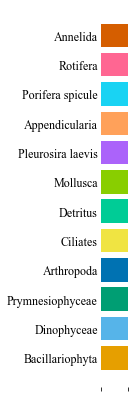

In [119]:
 # extract the x labels and y values from the dictionary
x_labels = list(tax_colors.keys())
y_values = list(tax_colors.values())
y_placeholders = [1] * len(y_values)

# create the bar plot
fig, ax = plt.subplots()
ax.barh(x_labels, y_placeholders, color=y_values)

ax.set_xlabel(None)
ax.set_xticklabels([])

# Remove the frame of the chart
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove y ticks, not labels
plt.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels(x_labels, fontsize=12, fontname='Times New Roman')

# Adjust the size
plt.gcf().set_size_inches(0.5, 7)

# Save legend as svg
fig.savefig(f"../figures/phytoplankton/legend.svg", format="svg", bbox_inches='tight')
fig.savefig(f"../figures/phytoplankton/legend.png", format="png", bbox_inches='tight')

plt.show()